In [40]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.io
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
import fgsm

In [2]:
paviaU = scipy.io.loadmat('./PaviaU.mat')['paviaU']
paviaU_gt = scipy.io.loadmat('./PaviaU_gt.mat')['paviaU_gt']

In [3]:
Nmax = paviaU.max()
paviaU = (paviaU/Nmax).astype(np.float32)

In [4]:
paviaU = paviaU.reshape(610*340, 103)

In [5]:
pca = PCA(10)
paviaU_PCA = pca.fit_transform(paviaU)

In [6]:
#mms = MinMaxScaler()
#paviaU_PCA = mms.fit_transform(paviaU_PCA)

In [7]:
def getiim(size,band):
    hf = int(size/2)
    aa = np.zeros(((610*340),size,size,band))
    a = np.zeros((610+size, 340+size, band))
    a[hf:-hf,hf:-hf,:] = paviaU_PCA.reshape((610,340,band))
    count = 0
    output = []
    for i in range(size,610-1):
        for j in range(size,340-1):
            #print(i,j)
            aa[count] = a[i-hf:i+hf,j-hf:j+hf,:]
            #print(count)
            count = count+1
    return aa

In [8]:
data_im = getiim(8,10)

In [9]:
data_im.shape

(207400, 8, 8, 10)

In [10]:
X = data_im
y = paviaU_gt.reshape(207400)
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]
nsplit = int(0.2*len(paviaU_PCA))
X_train = X[:nsplit]
y_train = y[:nsplit]
X_val = X[nsplit:nsplit*2]
y_val = y[nsplit:nsplit*2]
X_test = X[nsplit*2:]
y_test = y[nsplit*2:]
X,y = None,None

In [11]:
y_train_encode = keras.utils.to_categorical(y_train)
y_val_encode = keras.utils.to_categorical(y_val)
y_test_encode = keras.utils.to_categorical(y_test)


In [23]:
def nnmodel(input_shape):
    X_input = keras.layers.Input((input_shape))
    X = keras.layers.Flatten()(X_input)
    X = keras.layers.Dense(2048)(X)
    X = keras.layers.LeakyReLU(alpha=0.2)(X)
    X = keras.layers.Dense(512)(X)
    X = keras.layers.LeakyReLU(alpha=0.2)(X)
    X = keras.layers.Dense(512)(X)
    X = keras.layers.LeakyReLU(alpha=0.2)(X)
    X = keras.layers.Dense(10,activation='softmax')(X)
    model = keras.models.Model(inputs=X_input, outputs=X, name='model')
    return model

In [29]:
mymodel = nnmodel(X_train[0].shape)
mymodel.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
mymodel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 8, 8, 10)]        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 2048)              1312768   
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 2048)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               1049088   
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               262656

In [30]:
mymodel.fit(X_train,y_train_encode,batch_size=64,epochs=100,validation_data=(X_val,y_val_encode))

Train on 41480 samples, validate on 41480 samples
Epoch 1/100
41480/41480 [==============================] - 3s 62us/sample - loss: 0.8691 - accuracy: 0.8003 - val_loss: 0.8350 - val_accuracy: 0.8109
Epoch 2/100
41480/41480 [==============================] - 2s 52us/sample - loss: 0.8128 - accuracy: 0.8053 - val_loss: 0.8057 - val_accuracy: 0.8104
Epoch 3/100
41480/41480 [==============================] - 2s 52us/sample - loss: 0.7965 - accuracy: 0.8057 - val_loss: 0.8005 - val_accuracy: 0.8113
Epoch 4/100
41480/41480 [==============================] - 2s 52us/sample - loss: 0.7759 - accuracy: 0.8061 - val_loss: 0.8290 - val_accuracy: 0.8081
Epoch 5/100
41480/41480 [==============================] - 2s 52us/sample - loss: 0.7598 - accuracy: 0.8068 - val_loss: 0.7882 - val_accuracy: 0.8120
Epoch 6/100
41480/41480 [==============================] - 4s 93us/sample - loss: 0.7423 - accuracy: 0.8083 - val_loss: 0.7990 - val_accuracy: 0.8002
Epoch 7/100
41480/41480 [=========================

Epoch 55/100
41480/41480 [==============================] - 2s 53us/sample - loss: 0.1772 - accuracy: 0.9410 - val_loss: 2.3082 - val_accuracy: 0.7834
Epoch 56/100
41480/41480 [==============================] - 2s 53us/sample - loss: 0.1468 - accuracy: 0.9485 - val_loss: 2.3620 - val_accuracy: 0.7697
Epoch 57/100
41480/41480 [==============================] - 2s 52us/sample - loss: 0.1717 - accuracy: 0.9432 - val_loss: 2.4844 - val_accuracy: 0.7494
Epoch 58/100
41480/41480 [==============================] - 3s 62us/sample - loss: 0.1660 - accuracy: 0.9439 - val_loss: 2.5067 - val_accuracy: 0.7580
Epoch 59/100
41480/41480 [==============================] - 3s 71us/sample - loss: 0.1622 - accuracy: 0.9458 - val_loss: 2.5139 - val_accuracy: 0.7700
Epoch 60/100
41480/41480 [==============================] - 2s 60us/sample - loss: 0.1726 - accuracy: 0.9419 - val_loss: 2.4356 - val_accuracy: 0.7468
Epoch 61/100
41480/41480 [==============================] - 2s 60us/sample - loss: 0.1437 - ac

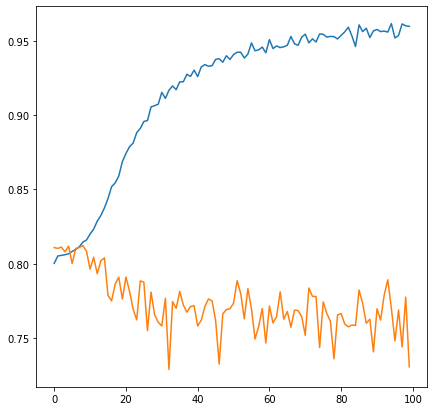

In [33]:
his = mymodel.history.history
plt.figure(figsize=(7,7))
plt.plot(his['accuracy'])
plt.plot(his['val_accuracy'])
#plt.savefig('ovf100ep.png')

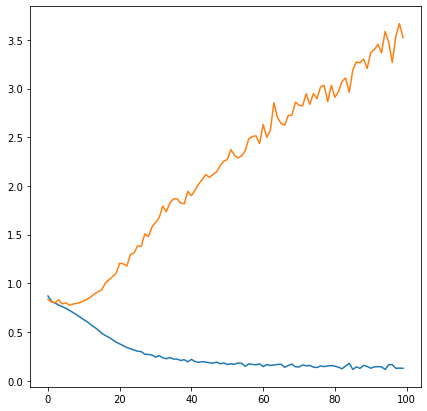

In [34]:
plt.figure(figsize=(7,7))
plt.plot(his['loss'])
plt.plot(his['val_loss'])

In [89]:
#mymodel.save('ovf100ep.h5')

In [38]:
print(classification_report(y_train,np.argmax(mymodel.predict(X_train),axis=1)))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96     32930
           1       0.57      0.97      0.72      1319
           2       0.83      0.90      0.86      3730
           3       0.96      0.97      0.97       413
           4       0.89      0.90      0.89       626
           5       0.98      0.97      0.97       265
           6       0.82      0.94      0.88      1035
           7       0.95      0.97      0.96       264
           8       0.86      0.94      0.90       715
           9       0.63      0.95      0.76       183

    accuracy                           0.94     41480
   macro avg       0.85      0.95      0.89     41480
weighted avg       0.95      0.94      0.94     41480



In [37]:
print(classification_report(y_val,np.argmax(mymodel.predict(X_val),axis=1)))

              precision    recall  f1-score   support

           0       0.84      0.85      0.84     33066
           1       0.06      0.10      0.08      1334
           2       0.53      0.45      0.48      3638
           3       0.07      0.03      0.04       405
           4       0.03      0.02      0.02       596
           5       0.15      0.05      0.08       260
           6       0.28      0.29      0.29      1026
           7       0.20      0.09      0.12       239
           8       0.07      0.05      0.06       718
           9       0.02      0.03      0.03       198

    accuracy                           0.73     41480
   macro avg       0.22      0.20      0.20     41480
weighted avg       0.73      0.73      0.73     41480



In [35]:
print(classification_report(y_test,np.argmax(mymodel.predict(X_test),axis=1)))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84     98628
           1       0.07      0.11      0.08      3978
           2       0.54      0.44      0.49     11281
           3       0.10      0.04      0.05      1281
           4       0.04      0.02      0.03      1842
           5       0.12      0.04      0.06       820
           6       0.26      0.28      0.27      2968
           7       0.21      0.10      0.14       827
           8       0.06      0.05      0.05      2249
           9       0.04      0.05      0.05       566

    accuracy                           0.73    124440
   macro avg       0.23      0.20      0.21    124440
weighted avg       0.72      0.73      0.72    124440



In [49]:
mymodel

In [55]:
def create_adversarial_pattern(input_image, input_label,models,loss_object = tf.keras.losses.CategoricalCrossentropy()):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = models(input_image)
        loss = loss_object(input_label, prediction)

      # Get the gradients of the loss w.r.t to the input image.
        gradient = tape.gradient(loss, input_image)
      # Get the sign of the gradients to create the perturbation
        signed_grad = tf.sign(gradient)
    return signed_grad

In [56]:
pn_tr = create_adversarial_pattern(tf.convert_to_tensor(X_train),tf.convert_to_tensor(y_train_encode),mymodel)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [58]:
pn_tr.shape

TensorShape([41480, 8, 8, 10])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


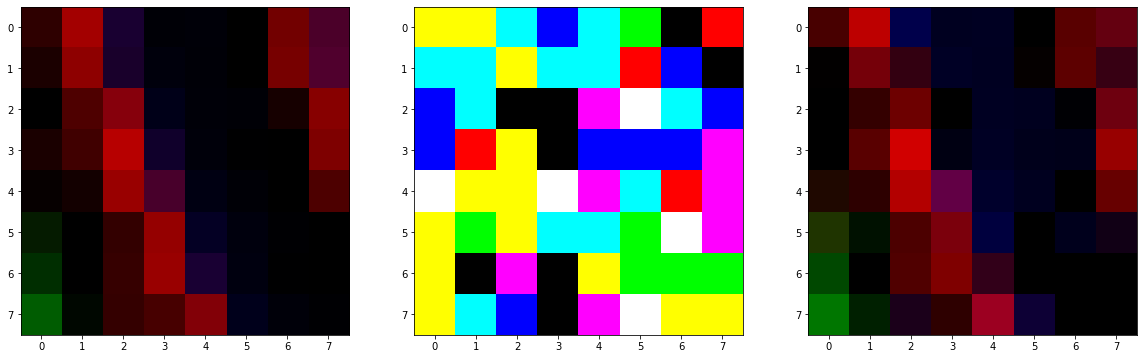

In [80]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,)
fig.set_figheight(20)
fig.set_figwidth(20)
ax1.imshow(X_train[212,:,:,:3])
ax2.imshow(pn_tr[212,:,:,:3])
ax3.imshow(X_train[212,:,:,:3]+0.1*pn_tr[212,:,:,:3])

In [82]:
pn_tr.shape

TensorShape([41480, 8, 8, 10])

In [83]:
xatk = X_train+0.1*pn_tr

In [85]:
mymodel.evaluate(xatk,y_train_encode,verbose=0)

[154.1939218283849, 0.36060753]

In [86]:
mymodel.evaluate(X_train,y_train_encode,verbose=0)

[0.19955683367170896, 0.93606555]

In [87]:
print(classification_report(y_train,np.argmax(mymodel.predict(xatk),axis=1)))

              precision    recall  f1-score   support

           0       0.76      0.39      0.51     32930
           1       0.04      0.32      0.08      1319
           2       0.11      0.13      0.12      3730
           3       0.16      0.34      0.22       413
           4       0.08      0.26      0.13       626
           5       0.26      0.46      0.33       265
           6       0.16      0.47      0.24      1035
           7       0.31      0.50      0.38       264
           8       0.05      0.24      0.09       715
           9       0.09      0.52      0.16       183

    accuracy                           0.36     41480
   macro avg       0.20      0.36      0.23     41480
weighted avg       0.63      0.36      0.44     41480



In [88]:
print(classification_report(y_train,np.argmax(mymodel.predict(X_train),axis=1)))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96     32930
           1       0.57      0.97      0.72      1319
           2       0.83      0.90      0.86      3730
           3       0.96      0.97      0.97       413
           4       0.89      0.90      0.89       626
           5       0.98      0.97      0.97       265
           6       0.82      0.94      0.88      1035
           7       0.95      0.97      0.96       264
           8       0.86      0.94      0.90       715
           9       0.63      0.95      0.76       183

    accuracy                           0.94     41480
   macro avg       0.85      0.95      0.89     41480
weighted avg       0.95      0.94      0.94     41480

